In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
# !pip install torch==1.5.1
!pip install tqdm
!pip install tensorboard
!pip install seqeval
! pip install tqdm
! pip install seaborn

     |████████████████████████████████| 1.9MB 8.7MB/s 
     |████████████████████████████████| 3.2MB 51.1MB/s 
     |████████████████████████████████| 890kB 55.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=bf5215319ddb97dad53e521ceaaa06d2afed06524566e51f42442df22deee6b9
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 51kB 4.4MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=f7dc5f148ecb0225e6811fd6ca48d926522ed0ab499ebaed8a25d78f09dc6afb
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [1]:
import os
import sys
import json
from tqdm import tqdm
sys.path.append("/content/drive/MyDrive/MovieEntityRecognizer")

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils import tensorboard
from seqeval.metrics import classification_report
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from transformers import (WEIGHTS_NAME, AdamW, BertConfig,
                                  BertForTokenClassification, BertTokenizerFast,
                                  get_linear_schedule_with_warmup)
from src.movientities.models.BertModel import BertNerModel
from src.movientities.data.analyze_dataset import Analyzer
from src.movientities.data.build_dataset import BuildData
from src.movientities.data.make_dataset import MakeData
from src.movientities.utils.processors import NerPreProcessor, NerDataset

<Figure size 432x288 with 0 Axes>

In [2]:
# Some initializers
train = True
num_train_epochs = 5
train_batch_size = 32
eval_batch_size = 8
# Weight decay for regularization
weight_decay = 0.01
# Now 1 but if batches wont fit RAM can be increased
gradient_accumulation_steps = 1
# %10 warm up
warmup_proportion = 0.1
# Adam variables
adam_epsilon = 1e-8
learning_rate = 5e-5
# 16 floating point instead of 32
fp16 = False
if fp16:
    # Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']
    fp16_opt_level
# max seq length (for engtrain.bio since the lengths are pretty short 128 is alright)
max_seq_length = 128
# For gradient clipping
max_grad_norm = 1.0
# For having flexibility over hardware
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Data path
data_dir = "/content/drive/MyDrive/MovieEntityRecognizer/data/modified"
# Tensorboard Name
tensorboard_writer = tensorboard.SummaryWriter("bert_base_uncased_default")

validate = True
test = True

In [3]:
# For downloading data, doesn't require ssl so if downloaded no need to run it again
# dataset_names = ["engtrain.bio", "engtest.bio", "trivia10k13train.n,bio", "trivia10k13test.bio"]
# (MakeData.download_data(os.path.join("http://groups.csail.mit.edu/sls/downloads/movie", dataset_name) for dataset_name in dataset_names)


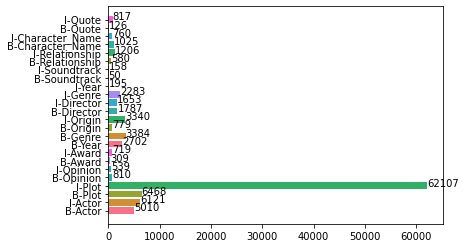

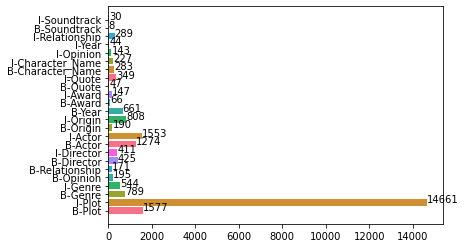

In [7]:
# Count also word frequencies and lengths or sentences
train_labels = Analyzer.count_labels("/content/drive/MyDrive/MovieEntityRecognizer/data/raw/trivia10k/trivia10k13train.bio", without_o=True)
Analyzer.plot_data(train_labels)
test_labels = Analyzer.count_labels("/content/drive/MyDrive/MovieEntityRecognizer/data/raw/trivia10k/trivia10k13test.bio", without_o=True)
Analyzer.plot_data(test_labels)

In [8]:
# Get distinct labels
label_list = sorted(list(train_labels.keys()))
label_list.append("O")
num_labels = len(label_list)
label_map = {label: id for id, label in enumerate(label_list)}
print(f"Size of labels of regular dataset: {len(label_list)}\n{label_map}")

Size of labels of regular dataset: 25
{'B-Actor': 0, 'B-Award': 1, 'B-Character_Name': 2, 'B-Director': 3, 'B-Genre': 4, 'B-Opinion': 5, 'B-Origin': 6, 'B-Plot': 7, 'B-Quote': 8, 'B-Relationship': 9, 'B-Soundtrack': 10, 'B-Year': 11, 'I-Actor': 12, 'I-Award': 13, 'I-Character_Name': 14, 'I-Director': 15, 'I-Genre': 16, 'I-Opinion': 17, 'I-Origin': 18, 'I-Plot': 19, 'I-Quote': 20, 'I-Relationship': 21, 'I-Soundtrack': 22, 'I-Year': 23, 'O': 24}


In [10]:
config = BertConfig.from_pretrained("bert-large-uncased", num_labels=num_labels, finetuning_task="ner")
tokenizer = BertTokenizerFast.from_pretrained("bert-large-uncased")
# model = BertNerModel.from_pretrained("bert-large-uncased",
#               from_tf = False,
#               config = config)

In [9]:
BuildData.create_finaldata("/content/drive/MyDrive/MovieEntityRecognizer/data/raw/trivia10k/trivia10k13train.bio", "/content/drive/MyDrive/MovieEntityRecognizer/data/modified/trivia10k/train.txt")
BuildData.create_finaldata("/content/drive/MyDrive/MovieEntityRecognizer/data/raw/trivia10k/trivia10k13test.bio", "/content/drive/MyDrive/MovieEntityRecognizer/data/modified/trivia10k/test.txt")


In [14]:
dataset = BuildData.create_dataset("/content/drive/MyDrive/MovieEntityRecognizer/data/modified/trivia10k")
id2label = {id: label for (label,id) in label_map.items()}
id2label[-100] = 'X'
id2label

{-100: 'X',
 0: 'B-Actor',
 1: 'B-Award',
 2: 'B-Character_Name',
 3: 'B-Director',
 4: 'B-Genre',
 5: 'B-Opinion',
 6: 'B-Origin',
 7: 'B-Plot',
 8: 'B-Quote',
 9: 'B-Relationship',
 10: 'B-Soundtrack',
 11: 'B-Year',
 12: 'I-Actor',
 13: 'I-Award',
 14: 'I-Character_Name',
 15: 'I-Director',
 16: 'I-Genre',
 17: 'I-Opinion',
 18: 'I-Origin',
 19: 'I-Plot',
 20: 'I-Quote',
 21: 'I-Relationship',
 22: 'I-Soundtrack',
 23: 'I-Year',
 24: 'O'}

In [15]:
if train:
    num_train_optimization_steps = int(
    len(dataset['train_instances']) / train_batch_size / gradient_accumulation_steps) * num_train_epochs
    print(f"Number of training steps {num_train_optimization_steps}")
    print(f"Number of training instances {len(dataset['train_instances'])}")

if test:
    test_steps = int(
    len(dataset['test_instances']) / eval_batch_size)
    print(f"Number of test steps {test_steps}")
    print(f"Number of test instances {len(dataset['test_instances'])}")

Number of training steps 1220
Number of training instances 7816
Number of test steps 244
Number of test instances 1953


In [16]:
train_tokens = tokenizer(dataset["train_instances"], is_split_into_words=True, return_offsets_mapping=True,
                            padding=True, truncation=True)

test_tokens = tokenizer(dataset['test_instances'], is_split_into_words=True, return_offsets_mapping=True, 
                            padding=True, truncation=True)

In [17]:
train_labels = NerPreProcessor.convert_labels(dataset["train_labels"], 
                                        label_map, 
                                        train_tokens)

test_labels = NerPreProcessor.convert_labels(dataset['test_labels'],
                                      label_map, 
                                      test_tokens)

In [18]:
if train_tokens["offset_mapping"]:
    train_tokens.pop("offset_mapping") 
if test_tokens["offset_mapping"]:
    test_tokens.pop("offset_mapping")

train_dataset = NerDataset(train_tokens, train_labels)
test_dataset = NerDataset(test_tokens, test_labels)

In [19]:
def model_init():
    model = BertForTokenClassification.from_pretrained('bert-large-uncased', num_labels=len(label_map))
    return model

In [21]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# function for computing monitoring metrics during training

def compute_metrics(p):

        predictions, labels = p
        predictions = np.argmax(predictions, axis=2)

        # Remove ignored index (special tokens)
        true_predictions = [
            [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        true_labels = [
            [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]

        preds_stretched = [label for doc in true_predictions for label in doc]
        trues_stretched = [label for doc in true_labels for label in doc]

        return {
            "accuracy_score": accuracy_score(trues_stretched, preds_stretched),
            "precision": precision_score(trues_stretched, preds_stretched, labels=np.unique(preds_stretched), average='macro'),
            "recall": recall_score(trues_stretched, preds_stretched, labels=np.unique(preds_stretched), average='macro'),
            "f1_macro": f1_score(trues_stretched, preds_stretched, labels=np.unique(preds_stretched), average='macro'),
            "f1_micro": f1_score(trues_stretched, preds_stretched, average='micro'),
        }

In [22]:
import numpy as np
from transformers import Trainer, TrainingArguments

# https://huggingface.co/transformers/main_classes/trainer.html
# boiler plate code from huggingface to launch a trainer instance
# sets directories and baseline configuration for batch sizes and weight decay
model_name = "bert-large-uncased-micro-10epoch-real-weight-decay-0-b64"
training_args = TrainingArguments(
    output_dir =  "/content/drive/MyDrive/MovieEntityRecognizer/pretrained_models/" +  model_name,          # output directory
    overwrite_output_dir = True,
    evaluation_strategy='epoch',
    num_train_epochs = 10,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.0,               # strength of weight decay
    logging_dir = "/content/drive/MyDrive/MovieEntityRecognizer/pretrained_models/" + model_name + '/logs',            # directory for storing logs
    logging_steps=10,
    load_best_model_at_end=True,
    learning_rate = 5e-5,
    seed = 5,
    gradient_accumulation_steps= 2
)

trainer = Trainer(                        # the instantiated 🤗 Transformers model to be trained
    model_init = model_init,
    args = training_args,                  # training arguments, defined above
    train_dataset = train_dataset,         # training dataset
    eval_dataset = test_dataset,
    compute_metrics = compute_metrics             # evaluation dataset
)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large

In [23]:
training_results = trainer.train()
evaluate_results_with_best_epoch = trainer.evaluate()

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-large

Epoch,Training Loss,Validation Loss,Accuracy Score,Precision,Recall,F1 Macro,F1 Micro,Runtime,Samples Per Second
0,0.748500,0.650034,0.812758,0.679529,0.499530,0.483817,0.812758,30.633900,63.753000
1,0.392900,0.381674,0.880492,0.725795,0.667386,0.676784,0.880492,30.674700,63.668000
2,0.326100,0.365803,0.883566,0.742064,0.747024,0.733751,0.883566,30.676800,63.664000
3,0.267000,0.371284,0.885564,0.765022,0.722459,0.733413,0.885564,30.674800,63.668000
4,0.231600,0.369628,0.888510,0.757870,0.753695,0.752267,0.888510,30.623000,63.776000
5,0.164000,0.407543,0.884309,0.755081,0.741015,0.743473,0.884309,30.706600,63.602000
6,0.111500,0.435503,0.884616,0.779797,0.740169,0.751517,0.884616,30.693300,63.630000
7,0.071000,0.493200,0.882029,0.754786,0.731344,0.737914,0.882029,30.632000,63.757000
8,0.046500,0.548891,0.885257,0.747006,0.739425,0.740429,0.885257,30.687600,63.641000
9,0.041700,0.584140,0.885206,0.742491,0.741735,0.739773,0.885206,30.522300,63.986000


Trivia 10 epoch 32 batch lr 5e-5 wd 0
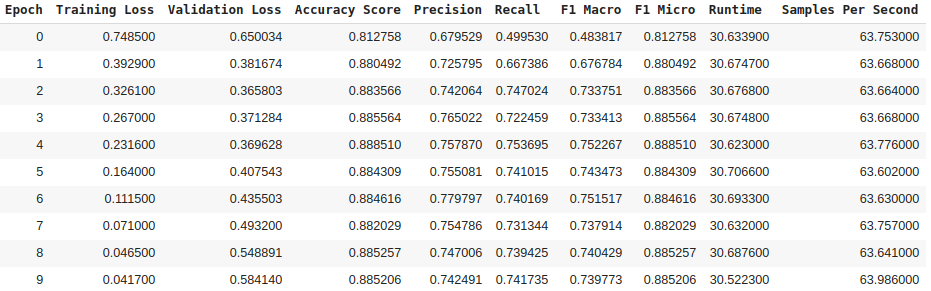